# Introduction to Genki Signals

### Signal Sources and Samplers

In [ ]:
import os

# NOTE: this isn't required when the library has been installed from PyPI
os.chdir('../')

The first building block of Genki Signals is the `SignalSource`

SignalSource is a callable that returns the current value of that Signal. It can be a function or a class with a `__call__` method. One example is the `MouseSource` that gives the current position of the pointer:

In [1]:
from genki_signals.sources import MouseSource, KeyboardSource

source = MouseSource()
keyboard_source = KeyboardSource(['m','e'])

Obviously we want to gather multiple samples of this signal. For that we need a `Sampler`.

A Sampler simply samples one or many SignalSources at a given _sample rate_:

In [2]:
from genki_signals.sources import Sampler

# sources is a dictionary mapping names to signal esources
sampler = Sampler(sources = {"mouse": source, "keyboard" : keyboard_source}, sample_rate=100)

Now the sampler samples the mouse position at a rate of 100 samples / second (hz) (This happens in a separate thread so the cell still returns and the main thread is unblocked.)

Signal Sources and Samplers are the way to get raw data into Genki Signals, usually from some external source, like a web API or an external device. Sometimes these will be combined into a single class, e.g. a microphone that samples audio data at a specific sample rate which we have no control over, but more on that later.

### Signal Functions and Systems

We might want to do some processing on the samples from our sampler. 

This is where SignalFunctions come in. SignalFunctions are functions that take in one or more signals and return another signal.

There is a collection of SignalFunctions available in `genki_signals.functions` and they all have a similar structure, to create one you need to specify some _input names_ and also a _name_ for the output signal: 

In [3]:
import genki_signals.functions as f

# diff differentiates the "mouse" signals with regard to the "timestamp" and returns the signal "mouse_vel"
# the "mouse" signal is the one we created earlier and "timestamp" is created automatically by the sampler

diff = f.Differentiate(input_a="mouse", input_b="timestamp", name="mouse_vel")

We need to introduce one more concept to connect all of this together: the System.

System takes in a Sampler/SignalSource and a list of SignalFunctions

In [4]:
from genki_signals.system import System

system = System(sampler, [diff])

system.start()

The `functions` module contains a library of functions to do signal arithmetic, digital signal processing, e.g. filtering, geometric calculations (useful for IMU sensors), create basic waveforms, run real time inference with machine learningh models, and more. We will dive into these in depth later.

### Visualization

This is the minimal setup we need. With a system, we can add signal functions to do all kinds of processing, and we can do data recording to start building a dataset. However, probably the most useful part of Genki Signals is the real-time visualization. For that we need a `Frontend`: 

In [5]:
from genki_signals.buffers import DataBuffer

buffer = DataBuffer()

system.register_data_feed(id(buffer), lambda d: buffer.extend(d))

In [6]:
buffer

DataBuffer(max_size=None, data=timestamp: (313,)
mouse: (2, 313)
keyboard_pressing_m: (313,)
keyboard_pressing_e: (313,)
mouse_vel: (2, 313))

In [7]:
%pip install genki_widgets

Note: you may need to restart the kernel to use updated packages.


In [10]:
#from genki_signals.frontends import WidgetFrontend
from genki_widgets import Trace

trace = Trace(('mouse', 0), ('mouse', 1), x_axis_visible = False, y_axis_visible = False, y_axis_flipped = True, n_visible_points = 100)



system.register_data_feed(id(trace), lambda d: trace.update(d.as_dict()))

In [11]:
trace

Trace(n_visible_points=100, sig_x={'key': 'mouse', 'idx': 0, 'name': ''}, sig_y=[{'key': 'mouse', 'idx': 1, 'n…

In [12]:
system.start_recording('a4')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'a4'

In [24]:
system.stop_recording()

A `WidgetFrontend` is a front end specifically designed for jupyter notebooks. In the above cell we create two `Line` widgets and combine them into a `dashboard` object that is then rendered in a notebook. A Genki Signals frontend can also be a separate web server or any sort of GUI to visualize and interact with the system. 

# Recording data

Our `dashboard` object displays the data in real time. The last basic feature we will introduce is recording. To start recording data, we can simply call `system.start_recording()` and give it a filename:

In [ ]:
system.start_recording('session_1')

The name `session_1` will be the name of a folder. We'll see its contents in a bit.

We are now recording data, try moving the mouse around a bit and run the next cell to stop recording (and stop everything):

In [ ]:
system.stop_recording()
system.stop()

The system created the folder `session_1`, let's see what it contains:

In [ ]:
!ls session_1/

`raw_data.pickle` contains the recorded data, whereas `metadata.json` contains various information about this recording session. Instead of reading these files directly we can load them in a `Session`:

In [26]:
from genki_signals.session import Session

session = Session.from_filename('b4')
session.raw_data

DataBuffer(max_size=None, data=timestamp: (2710,)
mouse: (2, 2710)
keyboard_pressing_m: (2710,)
keyboard_pressing_e: (2710,))

In [27]:
mouse_position_data = session.raw_data['mouse']

In [28]:
import matplotlib

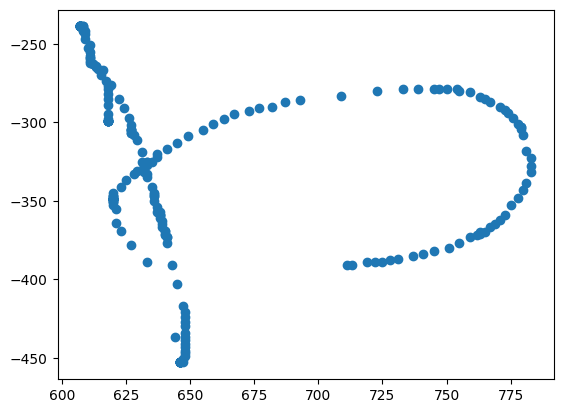

Error computing signal function mouse_vel
Traceback (most recent call last):
  File "c:\Users\Lenovo\anaconda3\envs\hakkathon\lib\site-packages\genki_signals\functions\base.py", line 49, in compute_signal_functions
    output = signal(*inputs)
  File "c:\Users\Lenovo\anaconda3\envs\hakkathon\lib\site-packages\genki_signals\functions\arithmetic.py", line 137, in __call__
    da = np.diff(a, prepend=prepend_a)
  File "<__array_function__ internals>", line 200, in diff
  File "c:\Users\Lenovo\anaconda3\envs\hakkathon\lib\site-packages\numpy\lib\function_base.py", line 1437, in diff
    a = np.concatenate(combined, axis)
  File "<__array_function__ internals>", line 200, in concatenate
ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)
Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\Lenovo\anaconda3\envs\hakkathon\lib\threading.py", line 980, in _boot

In [ ]:
import matplotlib.pyplot as plt

#for i in range:(6486)
plt.scatter(mouse_position_data[0, 250:500], -mouse_position_data[1, 250:500])

So we have a dataset of mouse positions! 

Note that we don't actually store the differentiated signal `mouse_vel`, we only store the raw data which is treated as a source of truth. The `SignalFunction`s are serialized and stored in `metadata.json`. All `SignalFunction`s are deterministic so they can be recomputed at will. This means that the signal functions (and their parameters, if any) can be used as hyperparameters in ML training. For example, if you want to use a low-pass filter on some signal, the exact cutoff frequency of the filter can be treated as a hyperparameter.

The `metadata.json` can also contain arbitrary information about the particular session. This can also be useful in a machine learning setting if you wish to, for example, make sure the data is split into train and test based on _individuals_, so that no individual who appears in the test set has any data in the training set. 

To recap, we have introduced a lot of concepts:

* A `SignalSource` is some way to get an external signal
* A `Sampler` samples values from a `SignalSource` at a given rate
* A `SignalFunction` is some function to process signals
* A `SignalSystem` ties all of the above together and records data
* A `Session` is some data that was recorded in a single recording session
* A `Frontend` is a way to visualize what is going on in a system and to interact with it

We have only scratched the surface of these components. This should be enough to get started but in the following notebooks we will cover each of these in more depth.